# **Image classification using CNN**

**Convolutional Neural Networks** are known for their astonishing capabilities in **image classification** tasks, as they capture complex patterns in data. In this Notebook we put them to the test.

In [2]:
import time
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import MNIST, SVHN
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA is {'' if torch.cuda.is_available() else 'not '}available")

CUDA is not available


## **Load the SVHN dataset**

In [91]:
train_dataset = SVHN(
    root="./data/svhn/train",
    split='train',
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

test_dataset = SVHN(
    root="./data/svhn/test",
    split='test',
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

extra_dataset = SVHN(
    root="./data/svhn/extra",
    split='extra',
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

Using downloaded and verified file: ./data/svhn/train\train_32x32.mat
Using downloaded and verified file: ./data/svhn/test\test_32x32.mat
Using downloaded and verified file: ./data/svhn/extra\extra_32x32.mat


We combine the train and extra dataset to form a larger one. We are going to use the large dataset for training our CNN.

In [4]:
train_dataset.data = np.concatenate(
    (train_dataset.data, extra_dataset.data[:70000]), axis=0
)

train_dataset.labels = np.concatenate(
    (train_dataset.labels, extra_dataset.labels[:70000]), axis=0
)

In [5]:
print(train_dataset.data.shape)
print(train_dataset.labels.shape)

(143257, 3, 32, 32)
(143257,)


As expected, **SVHN** dataset consists of images with 3 color channels (RGB), 32 height and 32 width each.

Helper functions 

In [6]:
def one_hot(data):
    return nn.functional.one_hot(data, num_classes=10).float()

def load_data(data, batch_size):
    return DataLoader(
        dataset=data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=0
    )

def score(model, dataloader, loss_fun=None):
    model = model.eval()
    correct = 0.0
    total = 0
    loss = 0.0

    with torch.inference_mode():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            y_model = model(data)
            predictions = torch.argmax(y_model, dim=1)
            correct += (labels == predictions).sum().item()
            total += labels.size(0)

            if not loss_fun:
                continue
            loss += loss_fun(y_model, one_hot(labels)).item()

    return correct / total, loss

## **Build the CNN model**

For our convolutional neural network, we use a single convolutional layer, followed by two linear transformations.

In [7]:
class CNN(nn.Module):
    def __init__(self,
                 input_channels,
                 conv_output,
                 hidden_neurons,
                 output_neurons,
                 kernel_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=conv_output,
            kernel_size=3,
            padding=1
        )
        self.conv_output = conv_output
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(conv_output * 16 * 16, hidden_neurons, bias=True)
        self.fc2 = nn.Linear(hidden_neurons, output_neurons, bias=True)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, self.conv_output * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## **Training phase**

Techniques used to train:
- **k-Fold Cross Validation**
- **Early stopping** based on validation loss, to prevent **overfitting**
- **Learning rate scheduling** to facilitate convergence even at later stages where weight adjustments seem to stagnate
- **Weighted Cross Entropy Loss** to compensate for the imbalanced dataset
- **Fine tuning** was performed manually because exhaustive search was taking days to finish

In [8]:
def train(
    model,
    train_data,
    test_data,
    k_folds,
    batch,
    optimizer,
    loss_function,
    lr_scheduler,
    device="cpu",
    patience=3,
    verbose=True,
):
    nsamples = len(train_data)
    fold_indices = torch.arange(nsamples)
    fold_size = nsamples // k_folds

    scores = {
        "Training": [],
        "Validation": [],
        "Test": []
    }

    losses = {
        "Training": [],
        "Validation": [],
        "Test": []
    }

    for fold in range(k_folds):
        best_validation_loss = float("inf")
        current_patience = 0

        start_index = fold * fold_size
        stop_index = min((fold + 1) * fold_size, nsamples)

        validation_indices = fold_indices[start_index:stop_index]
        train_indices = torch.cat([
            fold_indices[:start_index],
            fold_indices[stop_index:]
        ])

        train_subset = Subset(train_data, train_indices)
        validation_subset = Subset(train_data, validation_indices)

        train_loader = load_data(train_subset, batch)
        validation_loader = load_data(validation_subset, batch)
        test_loader = load_data(test_data, batch)

        for epoch in range(num_epochs):
            model.train()
            loss = 0.0
            correct = 0;
            total = 0;

            for X, y in train_loader:
                X = X.to(device)
                y = y.to(device)
                y_hot = one_hot(y)

                optimizer.zero_grad()
                y_model = model(X)
                batch_loss = loss_function(y_model, y_hot)
                batch_loss.backward()
                optimizer.step()
                loss += batch_loss.item()
                
                predictions = torch.argmax(y_model, dim=1)
                correct += (y == predictions).sum().item()
                total += y.size(0)

            lr_scheduler.step(loss)
            model.eval()

            training_score = correct / total
            
            validation_score, validation_loss = score(
                model, validation_loader, loss_function
            )
            test_score, test_loss = score(
                model, test_loader, loss_function
            )

            scores["Training"].append(training_score)
            scores["Validation"].append(validation_score)
            scores["Test"].append(test_score)

            losses["Training"].append(loss)
            losses["Validation"].append(validation_loss)
            losses["Test"].append(test_loss)

            if validation_loss < best_validation_loss:
                best_validation_loss = validation_loss
                current_patience = 0
            else:
                current_patience += 1
                if current_patience >= patience:
                    print(f"Early stopping: Validation loss didn't improve for "
                          f"{current_patience} epochs.\n")
                    break

            if not verbose:
                continue

            print(f"Epoch: {epoch}/{num_epochs}")
            print(f"Loss: {loss:.2f}")
            print(f"Training: {training_score}")
            print(f"Validation: {validation_score}")
            print(f"Test: {test_score}\n")

    return scores, losses, model

Select training parameters

In [9]:
from sklearn.utils.class_weight import compute_class_weight

k_folds = 5
input_size = 32 * 32 * 3
batch_size = 128
hidden_neurons = 256
learning_rate = 0.0005
filters = 32
output_size = 10
num_epochs = 15
patience = 4
kernel = 4

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_dataset.labels),
    y=train_dataset.labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

Train our CNN model using the large dataset

In [10]:
print(f"\nTraining model with hidden_neurons={hidden_neurons}, "
        f"batch={batch_size}, lr={learning_rate}, "
        f"filters={filters}")

cnnmodel = CNN(
    input_channels=3,
    conv_output=filters,
    hidden_neurons=hidden_neurons,
    output_neurons=output_size,
    kernel_size=kernel
).to(device)

loss_function = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(
    cnnmodel.parameters(),
    lr=learning_rate
)

scheduler = ReduceLROnPlateau(
    optimizer,
    factor=0.3,
    patience=2,
    verbose=True
)

start = time.time()

scores, losses, cnnmodel = train(
    cnnmodel,
    train_dataset,
    test_dataset,
    k_folds,
    batch_size,
    optimizer,
    loss_function,
    scheduler,
    device,
    patience,
    verbose=True
)

end = time.time()
print(f"\nTraining duration: {end - start}\n")


Training model with hidden_neurons=512, batch=256, lr=0.0005, filters=32
Epoch: 0/15
Loss: 548.32
Training: 0.62361052852349
Validation: 0.7442286036036037
Test: 0.7324798886138614

Epoch: 1/15
Loss: 264.52
Training: 0.8346616331096197
Validation: 0.8091216216216216
Test: 0.8000077351485149

Epoch: 2/15
Loss: 206.16
Training: 0.8739251258389261
Validation: 0.8291807432432432
Test: 0.8140857054455446

Epoch: 3/15
Loss: 177.19
Training: 0.8928009647651006
Validation: 0.8550112612612613
Test: 0.8441754331683168

Epoch: 4/15
Loss: 157.96
Training: 0.9040740352348994
Validation: 0.8604659346846847
Test: 0.854269801980198

Epoch: 5/15
Loss: 143.64
Training: 0.9131449244966443
Validation: 0.8644073761261262
Test: 0.8582920792079208

Epoch: 6/15
Loss: 132.56
Training: 0.9194718260626398
Validation: 0.8595157657657657
Test: 0.8506729579207921

Epoch: 7/15
Loss: 123.48
Training: 0.9246539429530202
Validation: 0.8698620495495496
Test: 0.8564743193069307

Epoch: 8/15
Loss: 115.63
Training: 0.9296

Eventually, we achieve the following **accuracies**:
- **Training dataset:**         96.1%
- **Validation dataset:**       98.7%
- **Test dataset:**             87.8%

# **Visualize the results**

In this section, we exhibit the performance of our model and the results using **multiple visualizations**.

First, we allocate a part of the dataset, that the model has never seen before, to use for additional testing.

In [11]:
extra_dataset.data = extra_dataset.data[270000:425000]
extra_dataset.labels = extra_dataset.labels[270000:425000]
random_loader = load_data(extra_dataset, batch_size)

print(f"Score on unknown set: {score(cnnmodel, random_loader)[0]}")

Score on unknown set: 0.9389785640495868


Our model performs great, achieving **93.9%** accuracy on new data.

The **diagrams** of the following section, illustrate the accuracy and loss across **training, validation and test** datasets during training.

In [12]:
import matplotlib.pyplot as plt

def plot(training_values, validation_values, metric):
    epoch_indices = torch.arange(len(training_values))

    plt.figure(figsize=(10, 6))
    plt.plot(
        epoch_indices,
        training_values,
        marker="o",
        label=f"{metric} on training data"
    )
    plt.plot(
        epoch_indices,
        validation_values,
        marker="s",
        label=f"{metric} on validation data"
    )
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

    plt.grid(True)
    plt.show()

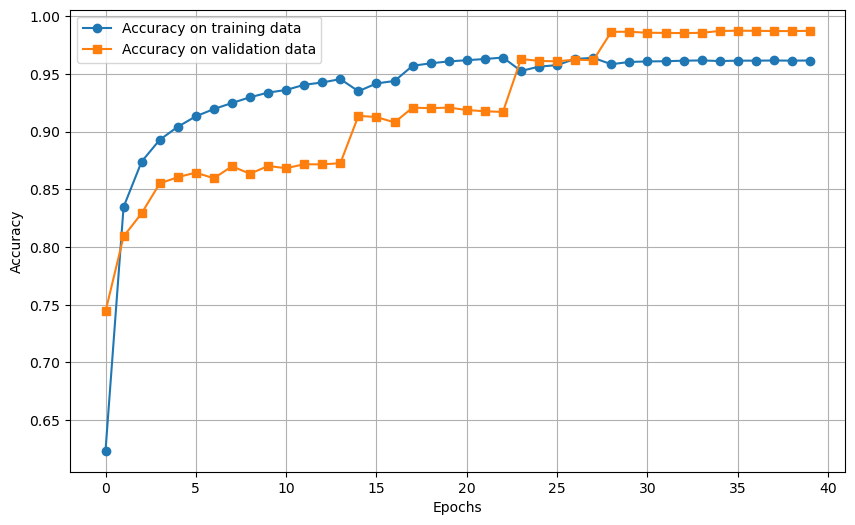

In [13]:
plot(scores["Training"], scores["Validation"], metric="Accuracy")

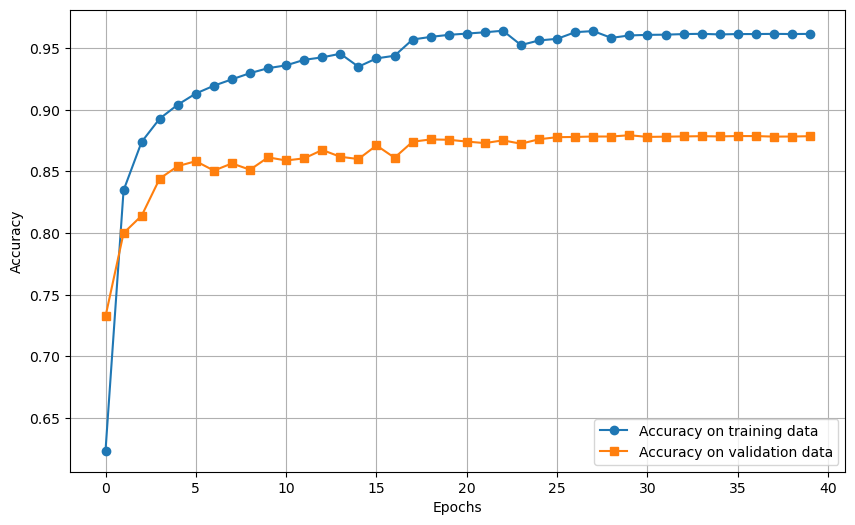

In [14]:
plot(scores["Training"], scores["Test"], metric="Accuracy")

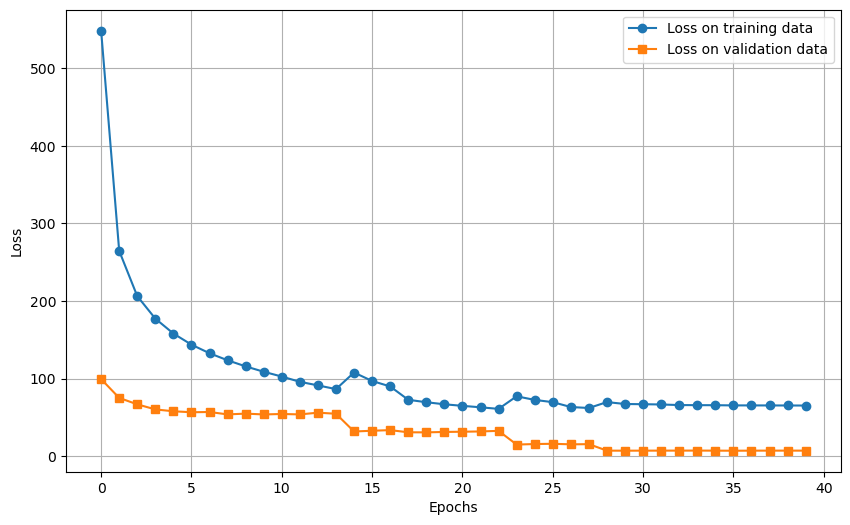

In [15]:
plot(losses["Training"], losses["Validation"], metric="Loss")

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, data, labels):
    with torch.inference_mode():
        predictions = torch.argmax(model(data), dim=1)

    cm = confusion_matrix(labels, predictions)
    class_labels = [str(i) for i in range(10)]
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

Now let's use a **Confusion Matrix** representation for our model's correct and mistaken predictions.

**Confusion Matrix** for the training dataset

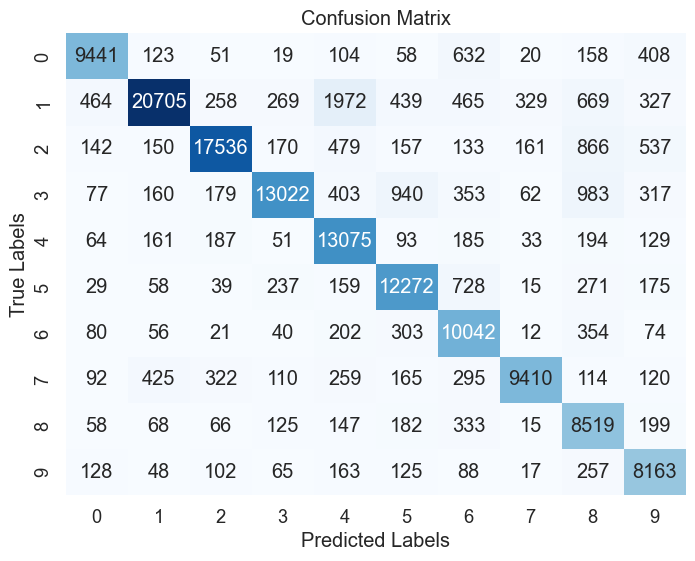

In [17]:
plot_confusion_matrix(
    cnnmodel.cpu(),
    torch.tensor(train_dataset.data).float(),
    train_dataset.labels
)

**Confusion Matrix** for the random dataset

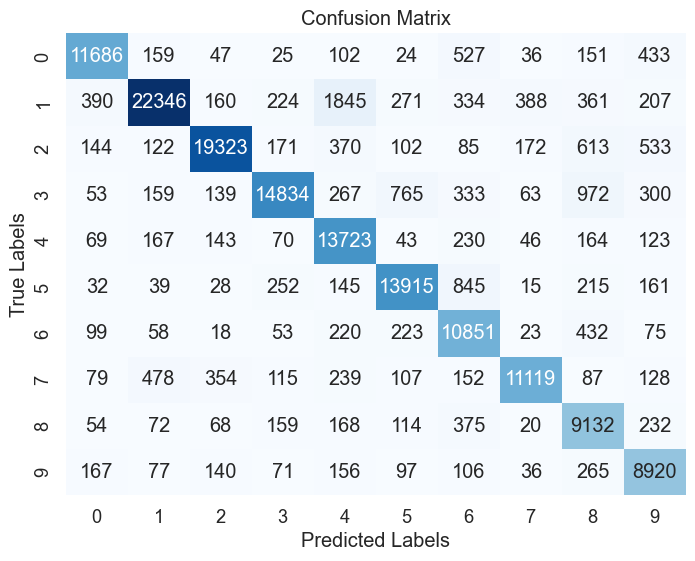

In [18]:
plot_confusion_matrix(
    cnnmodel.cpu(),
    torch.tensor(extra_dataset.data).float(),
    extra_dataset.labels
)

We notice specific patterns in the model's performance. Our model seems to make the most mistakes in cases where the two numbers (predicted, true), look alike or are characterized by similar patterns. For example, we see that for number **1**, the vast amount of mistakes was caused by prediction **4**. Similarly, for **3** most mistaken guesses are **8s** and for **7** it's **1s**.

## **Correct and wrong predictions**

Let's be more specific on the cases where our model performs good versus bad. Can we justify the bad predictions? 

In [152]:
def display_digits(dataset, indices, pred=None):
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 5))

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.view(32, 32, 3)
        image = image.squeeze().numpy()
        axes[i].imshow(image, cmap='gray')
        
        predicted = ""
        if pred:
            predicted = f", Predicted: {pred[i]}"
            
        axes[i].set_title(f'Label: {label}' + predicted)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [97]:
X = torch.tensor(extra_dataset.data).float()
y = extra_dataset.labels

In [93]:
extra_dataset = SVHN(
    root="./data/svhn/extra",
    split='extra',
    download=True,
    transform=transforms.ToTensor()
)

Using downloaded and verified file: ./data/svhn/extra\extra_32x32.mat


Below, are some images which our model classifies correctly.

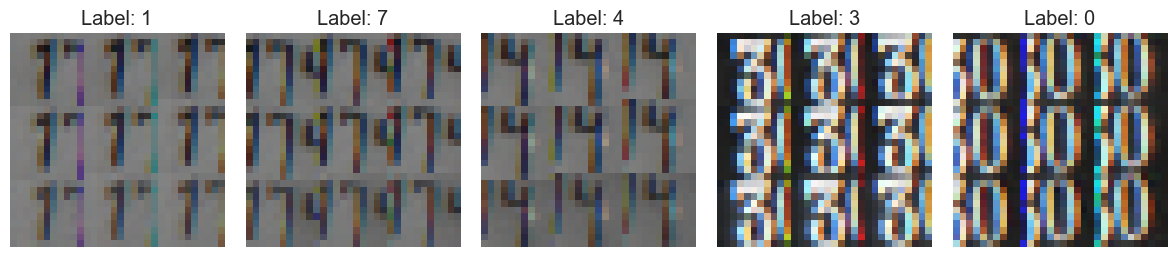

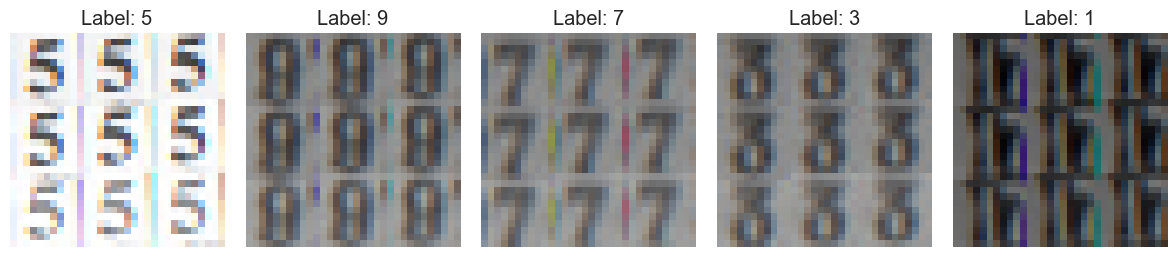

In [125]:
display_digits(extra_dataset, range(5, 10))
display_digits(extra_dataset, range(1000, 1005))

Now let's take a look at cases where our model miss-classifies pictures.

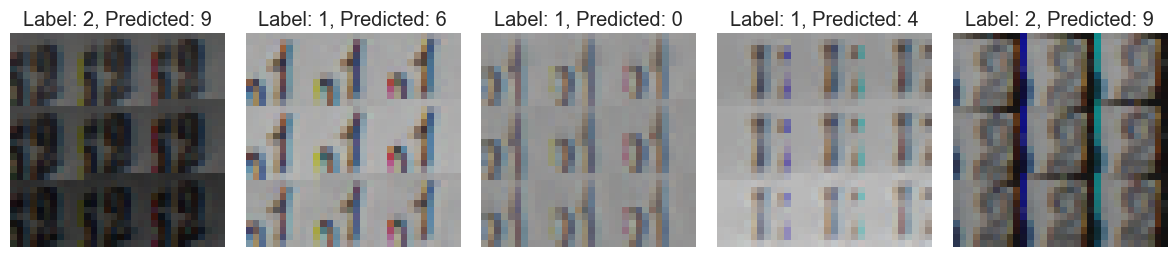

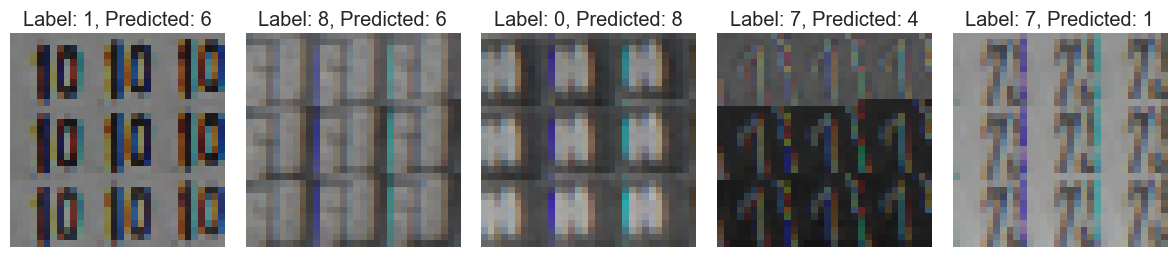

In [154]:
display_digits(extra_dataset, [50, 103, 536, 2109, 7607], pred=[9, 6, 0, 4, 9])
display_digits(extra_dataset, [70020, 70071, 7031, 1, 10103], pred=[6, 6, 8, 4, 1])

Obviously, these are really hard to get right, even for a real person, so i wouldn't completely blame our model for miss-classifying them :)  

# **Classification using k-Nearest-Neighbors**

Let's see how **k-NN** can perform on image classification tasks. My expectations are not particularly high as k-NN models don't really learn from a dataset, but rather store it and classify new data based on where it lands (distance wise) on the already stored samples.

Although useful for some tasks (for example quick vector search in vector databases), it's not well suited for the complex task of image classification.

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

**Standardization** and **Dimensionality Reduction**

**Standardization** is done to **normalize the distances** between samples, as relative distance is the most critical parameter that a k-NN model bases its classification decision on. 

In [73]:
ncomponents = 800
pca = PCA(ncomponents, whiten=True)

In [74]:
train_loader = load_data(train_dataset, 2048)
reduced_data = []
scaler = StandardScaler()

for X, y in train_loader:
    X = X.numpy()
    X = X.reshape(X.shape[0], -1)
    X = scaler.fit_transform(X)
    X = pca.fit_transform(X)
    reduced_data.append(X)

reduced_data = np.concatenate(reduced_data, axis=0)
reduced_data.shape

(141312, 800)

In [78]:
extra_loader = load_data(extra_dataset, 2048)
random_reduced_data = []
scaler = StandardScaler()

for X, y in extra_loader:
    X = X.numpy()
    X = X.reshape(X.shape[0], -1)
    X = scaler.fit_transform(X)
    X = pca.fit_transform(X)
    random_reduced_data.append(X)

random_reduced_data = np.concatenate(random_reduced_data, axis=0)
random_reduced_data.shape

(153600, 800)

**kNN with k=1**

In [79]:
knnmodel = KNeighborsClassifier(n_neighbors=1)
knnmodel.fit(reduced_data, train_dataset.labels[:reduced_data.shape[0]])

KNeighborsClassifier(n_neighbors=1)

In [80]:
y_pred = knnmodel.predict(reduced_data)
accuracy = np.mean(y_pred == train_dataset.labels[:reduced_data.shape[0]])
print(f'Accuracy with k=1: {accuracy:.2f}')

Accuracy with k=1: 1.00


In [81]:
y_pred = knnmodel.predict(random_reduced_data)
accuracy = np.mean(y_pred == extra_dataset.labels[random_reduced_data.shape[0]])
print(f'Accuracy on unknown dataset: {accuracy:.2f}')

Accuracy on unknown dataset: 0.06


**kNN with k=3**

In [82]:
knnmodel2 = KNeighborsClassifier(n_neighbors=3)
knnmodel2.fit(reduced_data, train_dataset.labels[:reduced_data.shape[0]])

KNeighborsClassifier(n_neighbors=3)

In [83]:
y_pred = knnmodel2.predict(reduced_data)
accuracy = np.mean(y_pred == train_dataset.labels[:reduced_data.shape[0]])
print(f'Accuracy with k=3: {accuracy:.2f}')

Accuracy with k=3: 0.41


Our **theoretical expectations are validated**, as it seems that k-NN model is not capable to predict with high accuracy.

# **Classification using Nearest Centroid**

In [84]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score

In [85]:
standardized_data = train_dataset.data / 255.0 * 2.0 - 1.0
standardized_data.shape

(143257, 3, 32, 32)

In [86]:
standardized_data = standardized_data.reshape(standardized_data.shape[0], -1)
standardized_data.shape

(143257, 3072)

In [87]:
ncmodel = NearestCentroid()
ncmodel.fit(standardized_data, train_dataset.labels)

NearestCentroid()

In [88]:
y_pred = ncmodel.predict(standardized_data)

In [89]:
(y_pred == train_dataset.labels).sum().item() / standardized_data.shape[0]

0.11334175642376987